# *In situ* data preparation

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import rasterio
from rasterio import features
import rasterio.plot
from IPython.display import display

import plotly.express as px
import plotly.offline
plotly.offline.init_notebook_mode()

print('All libraries successfully imported!')
print(f'Pandas    : {pd.__version__}')
print(f'GeoPandas : {gpd.__version__}')

All libraries successfully imported!
Pandas    : 1.4.2
GeoPandas : 0.9.0


## Set directory

In [2]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
computer_path = 'H:/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

clipped_path = f'{work_path}2_L2A_CLIPPED/'
in_situ_path = f'{work_path}IN_SITU/'

## Set parameters

In [3]:
site = 'NAMUR'
year = '2020'

no_data = -999

field_id = 'id'
field_classif_code = 'grp_1_nb'
field_classif_name = 'grp_1'
buffer_size   = -10
pix_min       = 3
pix_ratio_min = 0.0002
poly_min      = 4

## Set filenames

In [4]:
in_situ_shp = f'{in_situ_path}{site}_{year}_IN_SITU_ROI.shp'

in_situ_tif = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_buffer.tif'

in_situ_prepared_shp = f'{in_situ_path}{site}_{year}_IN_SITU_ROI_prepared.shp'

## 1. Apply 10m inner buffer to each polygons

In [5]:
gdf = gpd.read_file(in_situ_shp)

print(f'The Coordinates Reference System is {gdf.crs} \n')

print(f'There are {len(gdf)} polygons BEFORE applying the {buffer_size}m buffer.')

gdf.geometry = gdf.geometry.buffer(buffer_size)

gdf = gdf[~gdf.geometry.is_empty]    # Remove empty geometries

print(f'There are {len(gdf)} polygons AFTER applying the {buffer_size}m buffer.')

display(gdf.head())


The Coordinates Reference System is epsg:32631 

There are 733 polygons BEFORE applying the -10m buffer.
There are 629 polygons AFTER applying the -10m buffer.


id  lc_nb                     lc  grp_nb                    grp  class_nb  \
0   1      3  Grassland and meadows      31  Grassland and meadows       319   
1   2      3  Grassland and meadows      31  Grassland and meadows       319   
2   3      3  Grassland and meadows      31  Grassland and meadows       319   
3   4      3  Grassland and meadows      31  Grassland and meadows       319   
4   5      3  Grassland and meadows      31  Grassland and meadows       319   

                   class  sub_nb                    sub  grp_1_nb  \
0  Grassland and meadows    3199  Grassland and meadows         3   
1  Grassland and meadows    3199  Grassland and meadows         3   
2  Grassland and meadows    3199  Grassland and meadows         3   
3  Grassland and meadows    3199  Grassland and meadows         3   
4  Grassland and meadows    3199  Grassland and meadows         3   

                   grp_1  grp_A_nb                  grp_A  \
0  Grassland and meadows         3  Grassland and meadows   
1  Grassland and meadows         3  Grassland and meadows   
2  Grassland and meadows         3  Grassland and meadows   
3  Grassland and meadows         3  Grassland and meadows   
4  Grassland and meadows         3  Grassland and meadows   

                                            geometry  
0  MULTIPOLYGON (((636113.254 5595481.323, 636113...  
1  POLYGON ((629775.101 5593157.573, 629778.482 5...  
2  POLYGON ((636748.981 5595728.374, 636750.028 5...  
3  MULTIPOLYGON (((630003.573 5594258.004, 630003...  
4  POLYGON ((636962.589 5595674.757, 636966.536 5...

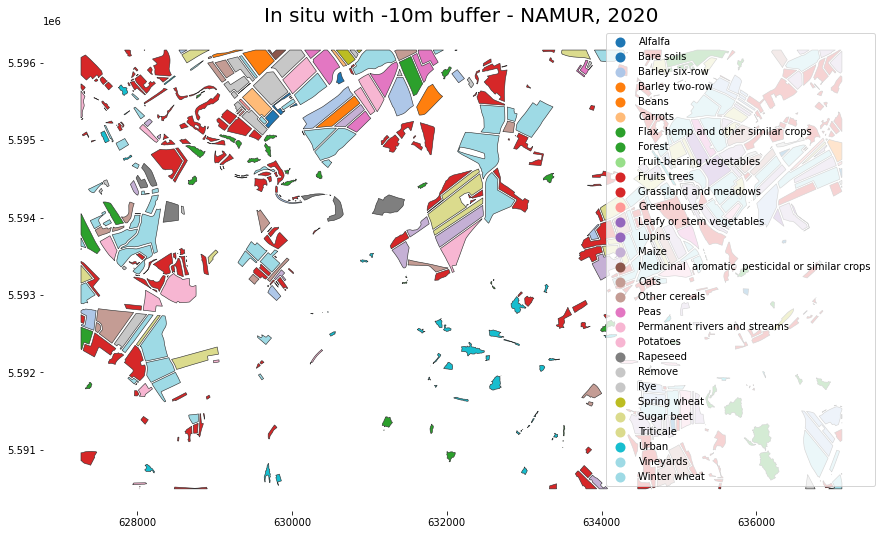

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

gdf.plot(ax=ax,
        column=field_classif_name,
        categorical=True,
        cmap='tab20',
        linewidth=.6,
        edgecolor='0.2',
        legend=True)

ax.set_title(f'In situ with {buffer_size}m buffer - {site}, {year}',fontsize=20)

plt.box(False)

## 2. Add polygon area

In [7]:
gdf['area'] = gdf.geometry.area.astype(int)

display(gdf.head())

id  lc_nb                     lc  grp_nb                    grp  class_nb  \
0   1      3  Grassland and meadows      31  Grassland and meadows       319   
1   2      3  Grassland and meadows      31  Grassland and meadows       319   
2   3      3  Grassland and meadows      31  Grassland and meadows       319   
3   4      3  Grassland and meadows      31  Grassland and meadows       319   
4   5      3  Grassland and meadows      31  Grassland and meadows       319   

                   class  sub_nb                    sub  grp_1_nb  \
0  Grassland and meadows    3199  Grassland and meadows         3   
1  Grassland and meadows    3199  Grassland and meadows         3   
2  Grassland and meadows    3199  Grassland and meadows         3   
3  Grassland and meadows    3199  Grassland and meadows         3   
4  Grassland and meadows    3199  Grassland and meadows         3   

                   grp_1  grp_A_nb                  grp_A  \
0  Grassland and meadows         3  Grassland and meadows   
1  Grassland and meadows         3  Grassland and meadows   
2  Grassland and meadows         3  Grassland and meadows   
3  Grassland and meadows         3  Grassland and meadows   
4  Grassland and meadows         3  Grassland and meadows   

                                            geometry   area  
0  MULTIPOLYGON (((636113.254 5595481.323, 636113...      0  
1  POLYGON ((629775.101 5593157.573, 629778.482 5...    235  
2  POLYGON ((636748.981 5595728.374, 636750.028 5...    251  
3  MULTIPOLYGON (((630003.573 5594258.004, 630003...   1735  
4  POLYGON ((636962.589 5595674.757, 636966.536 5...  14331

## 3. Add pixel count

### 3.1 Select one raster clipped to the extent of the ROI as a template to rasterize *in situ* polygons

In [8]:
img_temp_tif = glob.glob(f'{clipped_path}*.tif')[0]

print(f'Raster template file : {img_temp_tif}')

Raster template file : H:/ndeffense/LBRAT2104/GROUP_X/WORK/2_L2A_CLIPPED\T31UFS_20200116T105309_B02_10m_ROI.tif


### 3.2 Rasterize *in situ* polygons

In [9]:
# Open the raster file you want to use as a template for rasterize

src = rasterio.open(img_temp_tif, "r")

# Update metadata

out_meta = src.meta
out_meta.update(dtype='int16',
                nodata=no_data)

# Burn the features into the raster and write it out

dst = rasterio.open(in_situ_tif, 'w+', **out_meta)
dst_arr = dst.read(1)

# this is where we create a generator of geom, value pairs to use in rasterizing

geom_col = gdf.geometry
code_col = gdf[field_id].astype(int)

shapes = ((geom,value) for geom, value in zip(geom_col, code_col))

in_situ_arr = features.rasterize(shapes=shapes,
                                 fill=no_data,
                                 out=dst_arr,
                                 transform=dst.transform,
                                 all_touched=False)     # If false, only pixels whose center is within the polygon will be burned in.

dst.write_band(1, in_situ_arr)

# Close rasterio objects
src.close()
dst.close()

print(f'Rasterize is done : {in_situ_tif}')

Rasterize is done : H:/ndeffense/LBRAT2104/GROUP_X/WORK/IN_SITU/NAMUR_2020_IN_SITU_ROI_buffer.tif


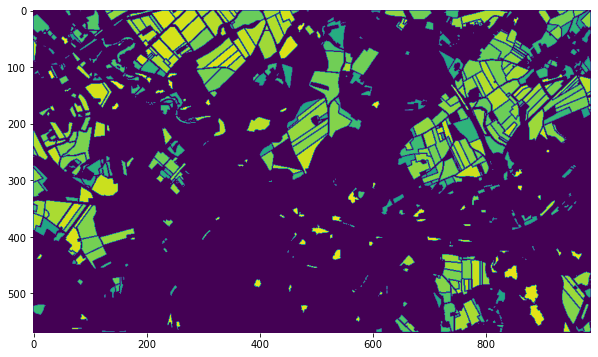

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

rasterio.plot.show(in_situ_arr, ax=ax)

plt.box(False)

### 3.3 Count number of pixels for each polygons

In [11]:
unique, counts = np.unique(in_situ_arr, return_counts=True)
pix_count_df = pd.DataFrame(zip(unique, counts), columns=['id','pix_count'], dtype='int16')

display(pix_count_df)

C:\Users\ndeffense\AppData\Local\Temp\ipykernel_34772\83254786.py:2: FutureWarning:

Values are too large to be losslessly cast to int16. In a future version this will raise OverflowError. To retain the old behavior, use pd.Series(values).astype(int16)



id  pix_count
0   -999     -12677
1      2          2
2      4         17
3      5        146
4      6         18
..   ...        ...
600  729         77
601  730         23
602  731         82
603  732         47
604  733         44

[605 rows x 2 columns]

### 3.4 Merge pixels count with polygons informations

In [13]:
pix_count_gdf = gdf.merge(pix_count_df, on='id', how="left")

display(pix_count_gdf.head())

print(f'There are {len(pix_count_gdf)} polygons')

id  lc_nb                     lc  grp_nb                    grp  class_nb  \
0   1      3  Grassland and meadows      31  Grassland and meadows       319   
1   2      3  Grassland and meadows      31  Grassland and meadows       319   
2   3      3  Grassland and meadows      31  Grassland and meadows       319   
3   4      3  Grassland and meadows      31  Grassland and meadows       319   
4   5      3  Grassland and meadows      31  Grassland and meadows       319   

                   class  sub_nb                    sub  grp_1_nb  \
0  Grassland and meadows    3199  Grassland and meadows         3   
1  Grassland and meadows    3199  Grassland and meadows         3   
2  Grassland and meadows    3199  Grassland and meadows         3   
3  Grassland and meadows    3199  Grassland and meadows         3   
4  Grassland and meadows    3199  Grassland and meadows         3   

                   grp_1  grp_A_nb                  grp_A  \
0  Grassland and meadows         3  Grassland and meadows   
1  Grassland and meadows         3  Grassland and meadows   
2  Grassland and meadows         3  Grassland and meadows   
3  Grassland and meadows         3  Grassland and meadows   
4  Grassland and meadows         3  Grassland and meadows   

                                            geometry   area  pix_count  
0  MULTIPOLYGON (((636113.254 5595481.323, 636113...      0        NaN  
1  POLYGON ((629775.101 5593157.573, 629778.482 5...    235        2.0  
2  POLYGON ((636748.981 5595728.374, 636750.028 5...    251        NaN  
3  MULTIPOLYGON (((630003.573 5594258.004, 630003...   1735       17.0  
4  POLYGON ((636962.589 5595674.757, 636966.536 5...  14331      146.0

There are 629 polygons


## 4. Remove unnecessary *in situ* polygons

### 4.1 Remove polygons with less than `pix_min` pixels

In [14]:
gdf = pix_count_gdf.loc[pix_count_gdf['pix_count'] >= pix_min]

gdf = gdf.astype({"pix_count": int})

print(f'There are {len(gdf)} polygons with more (or equal) than {pix_min} pixels.')

There are 583 polygons with more (or equal) than 3 pixels.


### 4.2 Remove polygons from under represented and unwanted classes

**Under represented** classes mean the classes with :
- not enough pixels - less than `pix_ratio_min`% of the total number of pixels (default : 0.0002%)
- not enough polygons - less than `poly_min` polygons (default : 5 polygons)

**Unwanted** classes mean the classes we don't want to work with

In [15]:
# Get number of pixels per class

pix_per_class_df = gdf.groupby([field_classif_code, field_classif_name])['pix_count'].agg('sum').to_frame().reset_index()
pix_per_class_df = pix_per_class_df.sort_values(by='pix_count', ascending=False)
pix_per_class_df['ratio'] = pix_per_class_df['pix_count'] / pix_per_class_df['pix_count'].sum()

# Get number of polygons per class

poly_per_class_df = gdf.groupby([field_classif_code, field_classif_name])[field_classif_code].agg('count').reset_index(name='poly_count')
poly_per_class_df = poly_per_class_df.sort_values(by='poly_count', ascending=False)

# Merge 2 previous dataframe in a single one
pix_poly_per_class_df = pix_per_class_df.merge(poly_per_class_df, on=[field_classif_code, field_classif_name], how="outer")

display(pix_poly_per_class_df)

grp_1_nb                                             grp_1  pix_count  \
0       1111                                      Winter wheat      29633   
1          3                             Grassland and meadows      23889   
2       1121                                             Maize       8667   
3       1811                                        Sugar beet       7400   
4       1152                                    Barley six-row       6659   
5       1511                                          Potatoes       6439   
6       1192                                     Other cereals       6117   
7          0                                            Remove       4068   
8       1771                                              Peas       3606   
9         69                                            Forest       3109   
10      1923                Flax  hemp and other similar crops       2810   
11        21                                      Fruits trees       2239   
12      1435                                          Rapeseed       1826   
13        81                                             Urban       1795   
14      1151                                    Barley two-row       1660   
15       121                          Leafy or stem vegetables       1351   
16      1711                                             Beans        835   
17      1171                                              Oats        776   
18      1231                                           Carrots        723   
19      1911                                           Alfalfa        554   
20      1112                                      Spring wheat        405   
21        84                                       Greenhouses        252   
22      1161                                               Rye        230   
23      9212                      Permanent rivers and streams        208   
24        22                                         Vineyards        178   
25      1115                                         Triticale        149   
26      1761                                            Lupins        140   
27      1931  Medicinal  aromatic  pesticidal or similar crops        138   
28        72                                        Bare soils         61   

       ratio  poly_count  
0   0.255640          74  
1   0.206087         221  
2   0.074769          36  
3   0.063839          21  
4   0.057446          20  
5   0.055548          14  
6   0.052771          17  
7   0.035094          28  
8   0.031108          10  
9   0.026821          35  
10  0.024241           8  
11  0.019316           7  
12  0.015753           6  
13  0.015485          36  
14  0.014321           3  
15  0.011655           4  
16  0.007203           2  
17  0.006694           8  
18  0.006237           2  
19  0.004779           7  
20  0.003494           3  
21  0.002174           5  
22  0.001984           2  
23  0.001794           4  
24  0.001536           4  
25  0.001285           1  
26  0.001208           2  
27  0.001191           1  
28  0.000526           2

In [16]:
list_all_classes             = set(pix_poly_per_class_df[field_classif_code].values)
list_under_represented_class = set(pix_poly_per_class_df.loc[(pix_poly_per_class_df['ratio'] < pix_ratio_min) | (pix_poly_per_class_df['poly_count'] < poly_min)][field_classif_code].values)
list_unwanted_class          = {0, 1992}

list_well_represented_class = set(list_all_classes - list_under_represented_class - list_unwanted_class)

print(f'---> {len(list_well_represented_class)} well-represented classes (>= {pix_ratio_min}% & >= {poly_min} polygons) :\n {sorted(list_well_represented_class)}')
print(f'---> {len(list_under_represented_class)} under-represented classes (< {pix_ratio_min}% & < {poly_min} polygons) :\n {sorted(list_under_represented_class)}')
print(f'---> {len(list_unwanted_class)} unwanted classes :\n {sorted(list_unwanted_class)}')

gdf = gdf.loc[gdf[field_classif_code].isin(list_well_represented_class)]

display(gdf.head())

print(f'There are {len(gdf)} polygons from well-represented classes.')

---> 19 well-represented classes (>= 0.0002% & >= 4 polygons) :
 [3, 21, 22, 69, 81, 84, 121, 1111, 1121, 1152, 1171, 1192, 1435, 1511, 1771, 1811, 1911, 1923, 9212]
---> 9 under-represented classes (< 0.0002% & < 4 polygons) :
 [72, 1112, 1115, 1151, 1161, 1231, 1711, 1761, 1931]
---> 2 unwanted classes :
 [0, 1992]


id  lc_nb                     lc  grp_nb                    grp  class_nb  \
3   4      3  Grassland and meadows      31  Grassland and meadows       319   
4   5      3  Grassland and meadows      31  Grassland and meadows       319   
5   6      3  Grassland and meadows      31  Grassland and meadows       319   
6   7      3  Grassland and meadows      31  Grassland and meadows       319   
7   9      3  Grassland and meadows      31  Grassland and meadows       319   

                   class  sub_nb                    sub  grp_1_nb  \
3  Grassland and meadows    3199  Grassland and meadows         3   
4  Grassland and meadows    3199  Grassland and meadows         3   
5  Grassland and meadows    3199  Grassland and meadows         3   
6  Grassland and meadows    3199  Grassland and meadows         3   
7  Grassland and meadows    3199  Grassland and meadows         3   

                   grp_1  grp_A_nb                  grp_A  \
3  Grassland and meadows         3  Grassland and meadows   
4  Grassland and meadows         3  Grassland and meadows   
5  Grassland and meadows         3  Grassland and meadows   
6  Grassland and meadows         3  Grassland and meadows   
7  Grassland and meadows         3  Grassland and meadows   

                                            geometry   area  pix_count  
3  MULTIPOLYGON (((630003.573 5594258.004, 630003...   1735         17  
4  POLYGON ((636962.589 5595674.757, 636966.536 5...  14331        146  
5  POLYGON ((635692.119 5593303.601, 635688.405 5...   1768         18  
6  POLYGON ((627911.368 5595749.375, 627942.033 5...   7828         79  
7  POLYGON ((633236.525 5596165.100, 633397.286 5...   3197         39

There are 537 polygons from well-represented classes.


## Plot histogram

In [17]:
df = pix_poly_per_class_df.loc[pix_poly_per_class_df[field_classif_code].isin(list_well_represented_class)]

display(df)

grp_1_nb                               grp_1  pix_count     ratio  \
0       1111                        Winter wheat      29633  0.255640   
1          3               Grassland and meadows      23889  0.206087   
2       1121                               Maize       8667  0.074769   
3       1811                          Sugar beet       7400  0.063839   
4       1152                      Barley six-row       6659  0.057446   
5       1511                            Potatoes       6439  0.055548   
6       1192                       Other cereals       6117  0.052771   
8       1771                                Peas       3606  0.031108   
9         69                              Forest       3109  0.026821   
10      1923  Flax  hemp and other similar crops       2810  0.024241   
11        21                        Fruits trees       2239  0.019316   
12      1435                            Rapeseed       1826  0.015753   
13        81                               Urban       1795  0.015485   
15       121            Leafy or stem vegetables       1351  0.011655   
17      1171                                Oats        776  0.006694   
19      1911                             Alfalfa        554  0.004779   
21        84                         Greenhouses        252  0.002174   
23      9212        Permanent rivers and streams        208  0.001794   
24        22                           Vineyards        178  0.001536   

    poly_count  
0           74  
1          221  
2           36  
3           21  
4           20  
5           14  
6           17  
8           10  
9           35  
10           8  
11           7  
12           6  
13          36  
15           4  
17           8  
19           7  
21           5  
23           4  
24           4

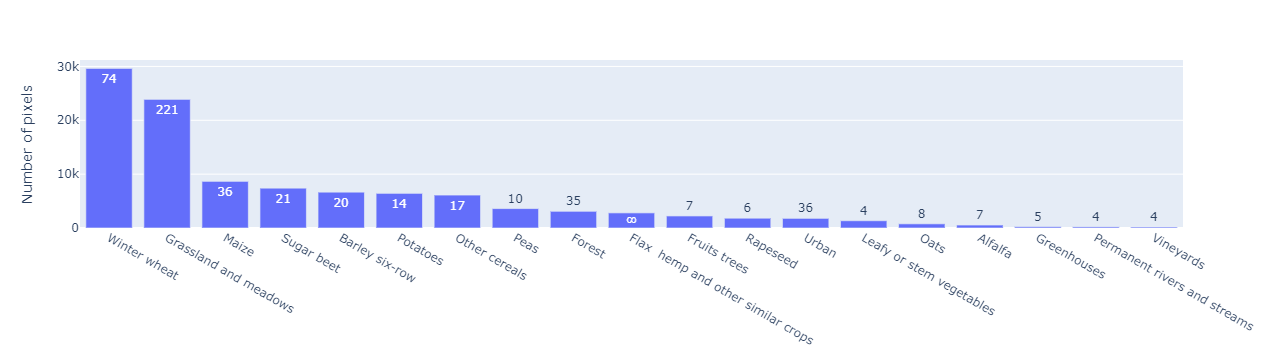

In [18]:
fig = px.bar(df,
             x=df[field_classif_name],
             y=df['pix_count'],
             text='poly_count',
             labels={'pix_count': 'Number of pixels'})

fig.update_layout(xaxis_title=None)


fig.show()

## Write geodataframe into a shapefile

In [ ]:
gdf.to_file(in_situ_prepared_shp)

print(f'New shapefile has been created : {in_situ_prepared_shp}')